In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import random
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier

import imblearn

import shap
shap.initjs()


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_style("whitegrid")

# Load Data

In [62]:
df_cus = pd.read_csv('../data/churn_dataset.csv')
df_cus = df_cus.loc[(df_cus.first_order_created_datetime >= "2017-01-01") & (df_cus.last_order_created_datetime < "2018-09-30")]

In [63]:
df_ord = pd.read_csv('../data/order_churn_data.csv')
df_ord = df_ord.merge(df_cus[['customer_db_id', 'completed_orders', 'laundry_distance', 'laundry_within_1km']], on='customer_db_id', how='inner')

df_ord['order_created_datetime'] = pd.to_datetime(df_ord.order_created_datetime)
df_ord.pickup_timeslot_from_datetime = pd.to_datetime(df_ord.pickup_timeslot_from_datetime)
df_ord.pickup_timeslot_to_datetime = pd.to_datetime(df_ord.pickup_timeslot_to_datetime)

df_ord['pickup_timeslot_from'] = df_ord.pickup_timeslot_from_datetime.dt.hour
df_ord['pickup_timeslot_to'] = df_ord.pickup_timeslot_to_datetime.dt.hour

df_ord.loc[df_ord.corporate, 'service_class'] = 'CORP'
df_ord['service_class_paid'] = False
df_ord.loc[df_ord.service_class.isin(['EXPRESS', 'PLUS']), 'service_class_paid'] = True

df_ord.voucher_revenue_ratio = df_ord.voucher_revenue_ratio.round(1)

In [64]:
df_items = pd.read_csv('../data/input/items.csv')[['order_id', 'product_group', 'quantity']]
df_items = df_items.groupby(['order_id', 'product_group']).max().unstack().fillna(0)
df_items.columns = ['prod_' + c for c in df_items.columns.get_level_values(1)]
df_items = pd.DataFrame(df_items.to_records())
df_ord = df_ord.merge(df_items, on='order_id', how='left')

In [65]:
df_clusters = pd.read_csv('../data/input/item_clusters_cities.csv')
# df_clusters['cluster'] = df_clusters.cluster.apply(lambda x: int(x[-1])).astype(int)
df_ord = df_ord.drop(['cluster'], axis=1).merge(df_clusters, on='order_id', how='left')

In [66]:
df_ord.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,prod_Shorts,prod_Skirt,prod_Skiwear,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,cluster
0,DE-A-00061,5a1ee6e144770903118b466f,5b69531a19207a30fd59e8af,52.491111,13.429692,2018-08-08 09:00:00,2018-08-08 10:00:00,12047,completed,2018-08-07 10:06:50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1
1,DE-B-20696,5a1ee6e144770903118b466f,5abe2737467709f94e8b4695,52.491111,13.429692,2018-04-04 06:00:00,2018-04-04 07:00:00,12047,completed,2018-03-30 14:01:59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,B_1
2,DE-B-72139,5a1ee6e144770903118b466f,5b8a56d5ee1b6a373e38f39c,52.491111,13.429692,2018-09-03 10:00:00,2018-09-03 11:00:00,12047,completed,2018-09-01 11:07:33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1
3,DE-B-87918,5a1ee6e144770903118b466f,5afc6c33c3436275d6724815,52.491111,13.429692,2018-05-22 07:00:00,2018-05-22 08:00:00,12047,completed,2018-05-16 19:36:51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,B_1
4,DE-C-27253,5a1ee6e144770903118b466f,5b20cb79ee1b6a090e115c25,52.491111,13.429692,2018-06-16 12:00:00,2018-06-16 13:00:00,12047,completed,2018-06-13 09:44:57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,B_1


In [67]:
sorted(df_ord.columns.tolist())

['activity_state',
 'aov',
 'churn_factor',
 'city',
 'cluster',
 'cluster_name',
 'completed_orders',
 'corporate',
 'customer_db_id',
 'customer_id',
 'customer_rescheduled',
 'days_since_last_order',
 'days_until_next_order',
 'delay_mins_DO',
 'delay_mins_PU',
 'driver_db_id_DO',
 'driver_db_id_PU',
 'email',
 'fac_name',
 'final_click_channel',
 'final_click_no_voucher',
 'frequency',
 'gender',
 'internal_rescheduled',
 'last_order',
 'laundry_distance',
 'laundry_within_1km',
 'newsletter_optin',
 'num_customer_reschedules',
 'num_internal_reschedules',
 'num_orders',
 'order_created_datetime',
 'order_db_id',
 'order_id',
 'order_num',
 'order_state',
 'order_x',
 'order_y',
 'origin',
 'pickup_timeslot_from',
 'pickup_timeslot_from_datetime',
 'pickup_timeslot_to',
 'pickup_timeslot_to_datetime',
 'pickup_zip',
 'prod_Accessories',
 'prod_Blazer',
 'prod_Blouse',
 'prod_Coats',
 'prod_Dress',
 'prod_DressSpecial',
 'prod_Household',
 'prod_Knitwear',
 'prod_Others',
 'prod_Shirt',
 'prod_Shorts',
 'prod_Skirt',
 'prod_Skiwear',
 'prod_Suit',
 'prod_Top',
 'prod_Trousers',
 'prod_Tshirt',
 'prod_Underwear',
 'prod_WashFold',
 'product_DC',
 'product_HH',
 'product_LA',
 'product_WF',
 'product_combinations',
 'product_type',
 'punctual_5min_DO',
 'punctual_5min_PU',
 'punctual_order',
 'rating',
 'rating_cleaning_quality',
 'rating_damaged_item',
 'rating_driver_conduct',
 'rating_ironing_quality',
 'rating_missing_items',
 'rating_punctuality',
 'recency',
 'reclean_order',
 'referred',
 'refund_approved',
 'refund_liability',
 'refund_request',
 'refund_type',
 'revenue',
 'segment',
 'service_class',
 'service_class_paid',
 'software_type',
 'voucher_channel',
 'voucher_revenue_ratio',
 'voucher_used',
 'voucher_value']

# Create Dataset
- only completed orders
- customers with at least 1 completed order
- calculate frequencies between completed orders

In [68]:
# only completed orders
df_comp = df_ord.loc[(df_ord.order_state == "completed") & (df_ord.completed_orders > 0)]
# df_comp = df_ord.loc[(df_ord.completed_orders > 0)]
df_comp = df_comp.sort_values(['customer_db_id', 'order_created_datetime'])

# number completed orders
df_comp['order_comp_num'] = df_comp.groupby(['customer_db_id']).cumcount()

# days
df_comp['next_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(-1)
df_comp['last_order_date'] = df_comp.groupby('customer_db_id')['order_created_datetime'].shift(1)
df_comp['days_until_next_comp'] = (df_comp.next_order_date - df_comp.order_created_datetime).dt.days
df_comp['days_since_last_comp'] = (df_comp.order_created_datetime - df_comp.last_order_date).dt.days
df_comp['weeks_until_next_comp'] = df_comp.days_until_next_comp // 7
df_comp['weeks_since_last_comp'] = df_comp.days_since_last_comp // 7

# frequency
df_comp['frequency_days_median'] = df_comp.groupby('customer_db_id')['days_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_weeks_median'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().median())
df_comp['frequency_weeks_diff'] = df_comp.weeks_since_last_comp - df_comp.frequency_weeks_median
df_comp['frequency_weeks_avg'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().mean())
df_comp['frequency_weeks_std'] = df_comp.groupby('customer_db_id')['weeks_since_last_comp'].transform(lambda x: x.expanding().std())

# revenue
df_comp['revenue_brutto'] = df_comp.revenue + df_comp.voucher_value
df_comp['last_order_revenue_brutto'] = df_comp.groupby('customer_db_id')['revenue_brutto'].shift(1)
df_comp['last_revenue_brutto_diff'] = df_comp.revenue_brutto - df_comp.last_order_revenue_brutto

# cluster
df_comp['last_order_cluster'] = df_comp.groupby(['customer_db_id'])['cluster'].shift(1)
df_comp['cluster_changed'] = (df_comp.cluster == df_comp.last_order_cluster)

df_comp['gender'] = df_comp.gender.map({'male': -1, 'female': 1}).fillna(0)

df_comp = df_comp.drop(['next_order_date', 'last_order_date', 'last_order_revenue_brutto'], axis=1)

In [69]:
# frequencies per each cluster, calcualted based on all customers
cluster_frequencies = df_comp.groupby('cluster').agg({'days_until_next_comp': 'median',
                                                           'weeks_until_next_comp': 'median'}).reset_index()
cluster_frequencies = cluster_frequencies.rename(columns={'days_until_next_comp': 'cluster_median_freq_days',
                                                          'weeks_until_next_comp': 'cluster_median_freq_weeks'})
df_comp = df_comp.merge(cluster_frequencies, on='cluster', how='left')

In [70]:
df_comp.to_csv('../data/old/comp_orders.csv', index=False)
df_comp.head()

,order_id,customer_db_id,order_db_id,order_x,order_y,pickup_timeslot_from_datetime,pickup_timeslot_to_datetime,pickup_zip,order_state,order_created_datetime,...,frequency_weeks_median,frequency_weeks_diff,frequency_weeks_avg,frequency_weeks_std,revenue_brutto,last_revenue_brutto_diff,last_order_cluster,cluster_changed,cluster_median_freq_days,cluster_median_freq_weeks
0,GB-W-59043,55e442dfd2cde8c51ec4d4a7,596214c2447709aa7c8b46c7,NaN,NaN,2017-07-09 18:30:00,2017-07-09 19:00:00,NW6 1QD,completed,2017-07-09 12:34:26,...,NaN,NaN,NaN,NaN,131.213242,NaN,NaN,False,22.0,3.0
1,GB-L-89887,5607e33cd4cde8db38c8d25c,58c3babb467709ea298b46ad,51.486661,0.033602,2017-03-12 19:30:00,2017-03-12 20:00:00,SE7 8AY,completed,2017-03-11 08:52:11,...,NaN,NaN,NaN,NaN,16.703310,NaN,NaN,False,15.0,2.0
2,GB-S-33739,56e8cfd2d4cde8b932bae6a9,5904c69c4577094a458b45fb,51.470018,-0.139703,2017-04-30 12:00:00,2017-04-30 12:30:00,SW8 3JD,completed,2017-04-29 18:00:12,...,NaN,NaN,NaN,NaN,60.091564,NaN,NaN,False,17.0,2.0
3,GB-B-78803,56e8cfd2d4cde8b932bae6a9,5941223e457709913d8b45c3,51.470018,-0.139703,2017-06-15 10:00:00,2017-06-15 10:30:00,SW8 3JD,completed,2017-06-14 12:47:10,...,6.0,0.0,6.0,NaN,54.067936,-6.023627,L_1,False,14.0,2.0
4,GB-H-60995,56e8cfd2d4cde8b932bae6a9,59709c45457709413c8b456a,51.470018,-0.139703,2017-07-21 10:30:00,2017-07-21 11:00:00,SW8 3JD,completed,2017-07-20 13:04:21,...,5.5,-0.5,5.5,0.707107,33.039048,-21.028888,L_6,True,14.0,2.0


# Filter Data
- per city
- only active customers
- orders where the next completed order within 2 and 150 days
- orders where last completed order within 2 and 150 days
- exclude corporate


# Dataset

In [166]:
num_completed_orders = 2
days_min = df_comp.days_until_next_comp.quantile(0.05)
days_max = df_comp.days_until_next_comp.quantile(0.95)
city = 'London'

In [167]:
days_min = 1
days_max = 60

In [168]:
cust_ids_excl = df_comp.loc[(df_comp.city != city) |
                            (df_comp.days_until_next_comp > days_max) | (df_comp.days_until_next_comp < days_min) |
                            (df_comp.days_since_last_comp > days_max) | (df_comp.days_since_last_comp < days_min) |
                            (df_comp.corporate) | (df_comp.voucher_channel.str.contains('CC|cc')) |
                            (df_comp.completed_orders < num_completed_orders)].customer_db_id.unique().tolist()
print(len(cust_ids_excl), '/', df_comp.customer_db_id.nunique())

27872 / 30175


In [169]:
df_city = df_comp.loc[~(df_comp.customer_db_id.isin(cust_ids_excl))]
df_city = df_city.loc[df_city.order_comp_num < num_completed_orders]

In [170]:
print('Num orders:', df_city.order_id.nunique())
print('Num customers:', df_city.customer_db_id.nunique())

Num orders: 4604
Num customers: 2303


In [171]:
known_cust = df_city[df_city.completed_orders > num_completed_orders].customer_db_id.unique()
unknown_cust = df_city[df_city.completed_orders == num_completed_orders].customer_db_id.unique()

df_known = df_city.loc[df_city.customer_db_id.isin(known_cust)]
df_unknown = df_city.loc[df_city.customer_db_id.isin(unknown_cust)]

In [172]:
print('Known customers:', len(known_cust))
print('Unknown customers:', len(unknown_cust))

Known customers: 1226
Unknown customers: 1077


In [173]:
df_known.order_id.nunique()

2452

In [174]:
df_known['days_until_next_comp_bin_cat'] = pd.qcut(df_known.days_until_next_comp.sort_values(), 10)
df_known['days_until_next_comp_bin'], bins = pd.qcut(df_known.days_until_next_comp.sort_values(), 10, labels=False, retbins=True)

In [175]:
df_known['days_since_last_comp_bin'] = pd.cut(df_known.days_since_last_comp.sort_values(), labels=False, 
                                              include_lowest=True, bins=bins)

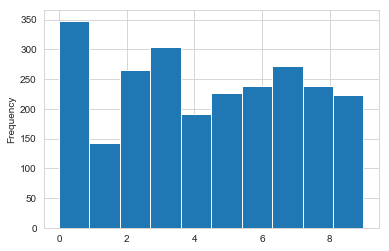

In [176]:
df_known.days_until_next_comp_bin.plot(kind='hist', bins=10)

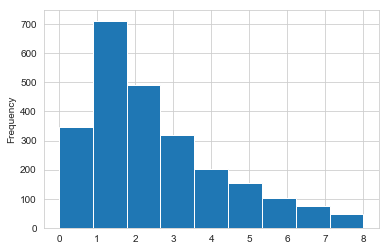

In [177]:
df_known.weeks_until_next_comp.plot(kind='hist', bins=df_known.weeks_until_next_comp.nunique())

In [178]:
cust_sample = random.sample(df_known.loc[df_known.completed_orders > 10].customer_db_id.unique().tolist(), 10)
cust_sample

['589f04734577093f2c8b4654',
 '5a70d0de447709f5718b46c9',
 '58890469457709e6628b4664',
 '58a43c7544770949278b45af',
 '58d6a32c457709ba128b4617',
 '5a8f029f46770921168b4643',
 '58d6676e457709ba128b45cd',
 '59516f70457709b1658b479a',
 '599ef58c467709ad418b45a9',
 '58fe094c4677091a1c8b45f9']

In [179]:
def plot_customer(customer_db_id):
    fig, ax= plt.subplots(figsize=(10,5))
    df_cust = df_comp.loc[df_comp.customer_db_id == customer_db_id]
    sns.lineplot(data=df_cust, x='order_num', y='days_until_next_comp', ax=ax)

In [180]:
cust_sample[5]

'5a8f029f46770921168b4643'

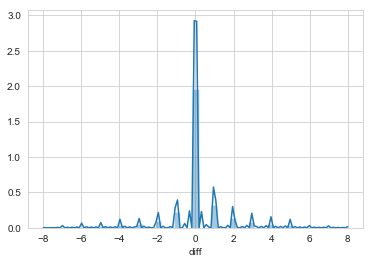

In [181]:
diff = df_known[['weeks_until_next_comp', 'weeks_since_last_comp']]
diff['diff'] = (df_known.weeks_until_next_comp - df_known.weeks_since_last_comp).fillna(0)
sns.distplot(diff['diff'])

weeks_since_last_comp
0.0    AxesSubplot(0.125,0.125;0.775x0.755)
1.0    AxesSubplot(0.125,0.125;0.775x0.755)
2.0    AxesSubplot(0.125,0.125;0.775x0.755)
3.0    AxesSubplot(0.125,0.125;0.775x0.755)
4.0    AxesSubplot(0.125,0.125;0.775x0.755)
5.0    AxesSubplot(0.125,0.125;0.775x0.755)
6.0    AxesSubplot(0.125,0.125;0.775x0.755)
7.0    AxesSubplot(0.125,0.125;0.775x0.755)
8.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: diff, dtype: object

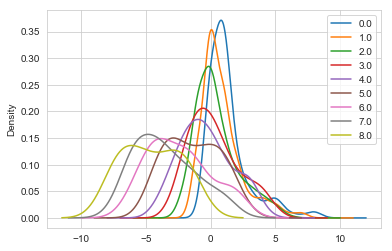

In [182]:
diff.groupby('weeks_since_last_comp')['diff'].plot(kind='kde', legend=True)

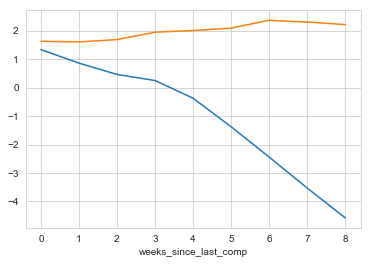

In [183]:
diff.groupby('weeks_since_last_comp')['diff'].mean().plot()
diff.groupby('weeks_since_last_comp')['diff'].std().plot()

In [184]:
week_mean_diff = diff.groupby('weeks_since_last_comp')['diff'].mean()
week_mean_diff

weeks_since_last_comp
0.0    1.333333
1.0    0.857534
2.0    0.460870
3.0    0.246753
4.0   -0.375000
5.0   -1.376812
6.0   -2.441860
7.0   -3.529412
8.0   -4.576923
Name: diff, dtype: float64

# Select Features
into customer features, prior features and last order features

In [185]:
df_known.shape

(2452, 114)

In [186]:
feats = [
    # behaviour
    'revenue_brutto', 'voucher_revenue_ratio', 'service_class_paid',
    'voucher_used', 'voucher_channel', 'software_type',
    'final_click_channel', 'frequency_weeks_median', 'frequency_weeks_diff',
    'weeks_since_last_comp', 'days_since_last_comp', 'frequency_days_median',
    'cluster_median_freq_weeks', 'last_revenue_brutto_diff',
    
    # items
    'cluster', 'laundry_distance', 'laundry_within_1km', 'cluster_changed']

feats_prod = [c for c in df_known.columns if 'prod_' in c]
# feats_prod = []

pred_name = 'weeks_until_next_comp'
baseline_name = 'weeks_since_last_comp'

# Fill NA

In [187]:
nans = df_known[feats].isnull().sum()
nans[nans > 0].sort_values(ascending=False)

voucher_channel             1967
last_revenue_brutto_diff    1226
frequency_days_median       1226
days_since_last_comp        1226
weeks_since_last_comp       1226
frequency_weeks_diff        1226
frequency_weeks_median      1226
laundry_within_1km           146
laundry_distance             146
dtype: int64

In [188]:
df_known.voucher_channel = df_known.voucher_channel.fillna('Unknown')
df_known.laundry_distance = df_known.laundry_distance.fillna(-999)
df_known.laundry_within_1km = df_known.laundry_within_1km.fillna(0)
df_known.frequency_weeks_diff = df_known.frequency_weeks_diff.fillna(0)
df_known.frequency_weeks_median = df_known.frequency_weeks_median.fillna(0)
df_known.cluster = df_known.cluster.fillna('0')
df_known.weeks_since_last_comp = df_known.weeks_since_last_comp.fillna(-1)
df_known.days_since_last_comp = df_known.days_since_last_comp.fillna(-1)
df_known.days_since_last_comp_bin = df_known.days_since_last_comp_bin.fillna(-1)
df_known.software_type = df_known.software_type.fillna('Unknown')
df_known.frequency_days_median = df_known.frequency_days_median.fillna(-1)
df_known[nans.index.tolist()] = df_known[nans.index.tolist()].fillna(0)

df_known[baseline_name] = df_known[baseline_name].fillna(0)

# Encode

In [189]:
str_cols = df_known[feats].select_dtypes(include='object').columns
df_known[str_cols] = df_known[str_cols].apply(LabelEncoder().fit_transform)

In [190]:
df_known_feats = df_known.set_index(['customer_db_id', 'order_comp_num']).unstack().swaplevel(axis=1)

In [191]:
df_known_last = df_known_feats[num_completed_orders-1][feats + feats_prod + [pred_name]].reset_index()
df_known_last.head()

,customer_db_id,revenue_brutto,voucher_revenue_ratio,service_class_paid,voucher_used,voucher_channel,software_type,final_click_channel,frequency_weeks_median,frequency_weeks_diff,...,prod_Shorts,prod_Skirt,prod_Skiwear,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,weeks_until_next_comp
0,56e8cfd2d4cde8b932bae6a9,54.067936,0.0,True,False,14,3,7,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1,5811cfc8d2cde8195c3e9560,19.021101,0.0,False,False,14,1,12,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2,5868cc73447709fd478b45c4,14.420827,0.0,True,False,14,1,18,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,58692418467709771e8b45e1,61.767764,0.0,False,False,14,1,17,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0
4,586a55a3447709f21f8b45b2,16.957509,0.0,True,False,14,3,20,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [192]:
df_known_last = df_known_last.fillna(-1)

In [193]:
df_known_prior = df_known_feats[list(range(num_completed_orders-1))]
df_known_prior = df_known_prior.swaplevel(axis=1)
df_known_prior = df_known_prior[feats + [pred_name]].fillna(-1)

df_known_prior = pd.DataFrame(df_known_prior.to_records())
df_known_prior.head()

,customer_db_id,"('revenue_brutto', 0)","('voucher_revenue_ratio', 0)","('service_class_paid', 0)","('voucher_used', 0)","('voucher_channel', 0)","('software_type', 0)","('final_click_channel', 0)","('frequency_weeks_median', 0)","('frequency_weeks_diff', 0)","('weeks_since_last_comp', 0)","('days_since_last_comp', 0)","('frequency_days_median', 0)","('cluster_median_freq_weeks', 0)","('last_revenue_brutto_diff', 0)","('cluster', 0)","('laundry_distance', 0)","('laundry_within_1km', 0)","('cluster_changed', 0)","('weeks_until_next_comp', 0)"
0,56e8cfd2d4cde8b932bae6a9,60.091564,0.2,True,True,5,3,8,0.0,0.0,-1.0,-1.0,-1.0,2.0,0.0,1,1513.453997,0.0,False,6.0
1,5811cfc8d2cde8195c3e9560,21.552149,0.0,False,False,14,1,11,0.0,0.0,-1.0,-1.0,-1.0,2.0,0.0,1,731.180362,1.0,False,4.0
2,5868cc73447709fd478b45c4,41.125609,0.0,True,False,14,1,18,0.0,0.0,-1.0,-1.0,-1.0,2.0,0.0,0,1856.733983,0.0,False,1.0
3,58692418467709771e8b45e1,84.385063,0.0,False,False,14,1,17,0.0,0.0,-1.0,-1.0,-1.0,2.0,0.0,11,117.443322,3.0,False,1.0
4,586a55a3447709f21f8b45b2,28.363165,0.0,True,False,14,1,17,0.0,0.0,-1.0,-1.0,-1.0,5.0,0.0,7,1222.162078,0.0,False,4.0


In [194]:
df_train = df_known_prior.merge(df_known_last, on='customer_db_id', how='left').set_index(['customer_db_id'])
df_train.head()

,"('revenue_brutto', 0)","('voucher_revenue_ratio', 0)","('service_class_paid', 0)","('voucher_used', 0)","('voucher_channel', 0)","('software_type', 0)","('final_click_channel', 0)","('frequency_weeks_median', 0)","('frequency_weeks_diff', 0)","('weeks_since_last_comp', 0)",...,prod_Shorts,prod_Skirt,prod_Skiwear,prod_Suit,prod_Top,prod_Trousers,prod_Tshirt,prod_Underwear,prod_WashFold,weeks_until_next_comp
customer_db_id,,,,,,,,,,,,,,,,,,,,,
56e8cfd2d4cde8b932bae6a9,60.091564,0.2,True,True,5,3,8,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
5811cfc8d2cde8195c3e9560,21.552149,0.0,False,False,14,1,11,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
5868cc73447709fd478b45c4,41.125609,0.0,True,False,14,1,18,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
58692418467709771e8b45e1,84.385063,0.0,False,False,14,1,17,0.0,0.0,-1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0
586a55a3447709f21f8b45b2,28.363165,0.0,True,False,14,1,17,0.0,0.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [195]:
# df_known_m = df_known_m.dropna()
df_train.shape

(1226, 57)

# Classification (Weeks)

In [196]:
def print_metric(true_y, pred_y, metric=metrics.accuracy_score, metric_name='Accuracy', kwargs=None):
    if not kwargs:
        kwargs = {}
    kwargs['y_true'] = true_y
    kwargs['y_pred'] = pred_y
    print(metric_name + ':', metric(**kwargs).round(5))
    
    return metric(**kwargs)

def print_accuracy(true_y, pred_y):
    print_metric(true_y, pred_y, metrics.accuracy_score, 'Accuracy')
    
def print_f1(true_y, pred_y):
    kwargs = {'average': 'weighted'}
    print_metric(true_y, pred_y, metrics.f1_score, 'F1 Score', kwargs)

def print_log_loss(true_y, pred_y):
    print_metric(true_y, pred_y, metrics.log_loss, 'Log Loss')
    
def print_r2_score(true_y, pred_y):
    print_metric(true_y, pred_y, metrics.r2_score)
    
def plot_confusion_mat(true_y, pred_y):
    sns.heatmap(metrics.confusion_matrix(true_y, pred_y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
def print_score(score, score_name):
    score = np.array(score)
    print(score_name + ':', "%0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2))
    
f1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
acc_scorer = metrics.make_scorer(metrics.accuracy_score)
r2_scorer = metrics.make_scorer(metrics.r2_score)

# Baseline
Predict the number since last order as until next order.

In [197]:
print_accuracy(df_known_last[pred_name], df_known_last[baseline_name])
print_f1(df_known_last[pred_name], df_known_last[baseline_name])

Accuracy: 0.27651
F1 Score: 0.27088


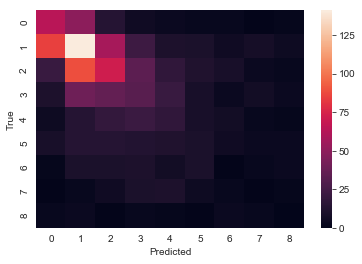

In [198]:
plot_confusion_mat(df_known_last[pred_name], df_known_last[baseline_name])

# Cross-Validation

In [199]:
X = df_train.drop(pred_name, axis=1).values
y = df_train[pred_name].values
n_classes = df_train[pred_name].nunique()
print('X:', X.shape)
print('y:', y.shape)
print('# Classes:', n_classes)

X: (1226, 56)
y: (1226,)
# Classes: 9


In [200]:
# one-vs-all (OVL)
ovl_class = [0, 1]
df_train_ovl_class = df_train.loc[df_train[pred_name].isin(ovl_class)]
df_train_ovl_others = df_train.loc[~df_train[pred_name].isin(ovl_class)].sample(len(df_train_ovl_class))
df_train_ovl = df_train_ovl_class.append(df_train_ovl_others)

X_ovl = df_train_ovl.drop(pred_name, axis=1).values
y_ovl = (df_train_ovl[pred_name].isin(ovl_class)).values.astype(int)
print('X_ovl', X_ovl.shape)
print('y_ovl', y_ovl.shape)

X_ovl (988, 56)
y_ovl (988,)


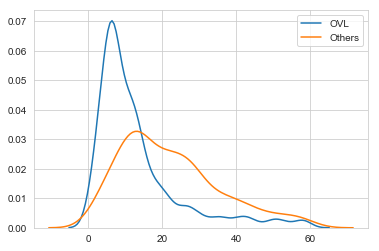

In [201]:
sns.kdeplot(df_train_ovl_class.days_since_last_comp, label='OVL')
sns.kdeplot(df_train_ovl_others.days_since_last_comp, label='Others')

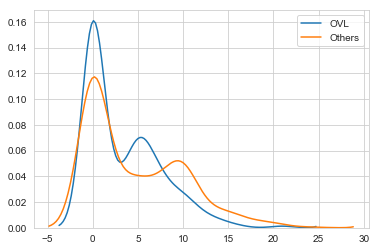

In [202]:
sns.kdeplot(df_train_ovl_class.prod_Shirt, label='OVL')
sns.kdeplot(df_train_ovl_others.prod_Shirt, label='Others')

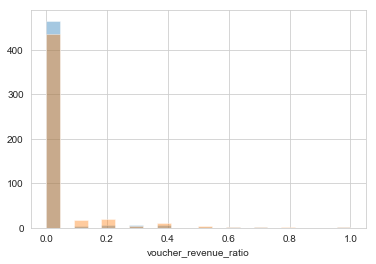

In [203]:
sns.distplot(df_train_ovl_class.voucher_revenue_ratio, label='OVL', kde=False)
sns.distplot(df_train_ovl_others.voucher_revenue_ratio, label='Others', kde=False)

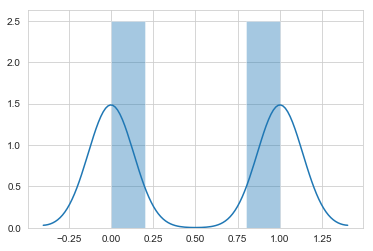

In [204]:
sns.distplot(y_ovl)

In [205]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm_ovl = scaler.fit_transform(X_ovl)

binarizer = LabelBinarizer()
y_binary = binarizer.fit_transform(y)

In [206]:
# Cross-Validation
kf = StratifiedKFold(n_splits=4)
kf.get_n_splits(X_norm)

4

In [207]:
kf_ovl = StratifiedKFold(n_splits=4)
kf.get_n_splits(X_norm_ovl)

4

In [208]:
def eval_model(clf, X_norm=X_norm, y=y):
    scores =  {'f1': [], 'acc': [], 'r2': [], 'logloss': []}

    for train, test in kf.split(X_norm, y):
        X_train, X_test = X_norm[train], X_norm[test]
        y_train, y_test = y[train], y[test]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        try:
            y_pred_proba = clf.predict_proba(X_test)
            scores['logloss'].append(metrics.log_loss(y_test, y_pred_proba, labels=df_train[pred_name].unique().tolist()))      
        except:
            pass
        
        try:
            scores['f1'].append(metrics.f1_score(y_test, y_pred, average='weighted'))
            scores['acc'].append(metrics.accuracy_score(y_test, y_pred))
            scores['r2'].append(metrics.r2_score(y_test, y_pred))
        except:
            pass

    print_score(scores['acc'], 'Accuracy')
    print_score(scores['r2'], 'R2 Score')
    print_score(scores['f1'], 'F1 Score')
    print_score(scores['logloss'], 'Log Loss')

# Logistic Regression

In [216]:
log_reg = linear_model.LogisticRegression()
eval_model(log_reg, X_norm, y)

Accuracy: 0.2715 (+/- 0.0186)
R2 Score: -0.2988 (+/- 0.1930)
F1 Score: 0.2206 (+/- 0.0116)
Log Loss: 1.9918 (+/- 0.0971)


In [210]:
log_reg = linear_model.LogisticRegression()
eval_model(log_reg, X_norm_ovl, y_ovl)

Accuracy: 0.6619 (+/- 0.0618)
R2 Score: -0.3523 (+/- 0.2472)
F1 Score: 0.6610 (+/- 0.0615)
Log Loss: nan (+/- nan)


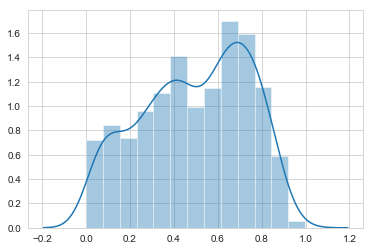

In [211]:
sns.distplot(log_reg.predict_proba(X_norm_ovl)[:, 1])

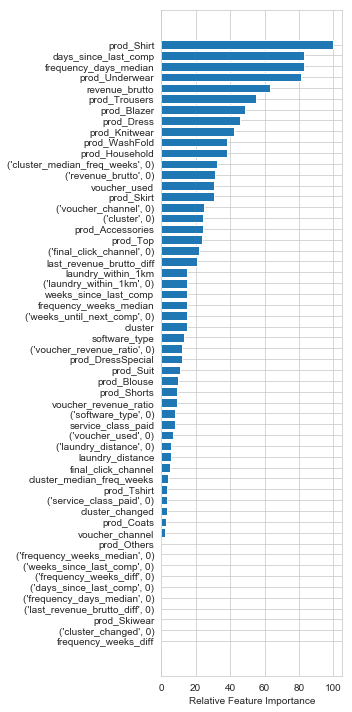

In [217]:
feature_importance = abs(log_reg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(5,10))
ax.barh(pos, feature_importance[sorted_idx])
ax.set_yticks(pos)
ax.set_yticklabels(np.array(df_train.drop(pred_name, axis=1).columns)[sorted_idx])
ax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [213]:
print_accuracy(y_ovl, (log_reg.predict_proba(X_norm_ovl)[:, 1] > 0.70).astype(int))

Accuracy: 0.65688


In [214]:
mlp = MLPClassifier(activation='tanh', alpha=0.1)
eval_model(mlp, X_norm, y)

Accuracy: 0.2453 (+/- 0.0584)
R2 Score: -0.3044 (+/- 0.2183)
F1 Score: 0.2286 (+/- 0.0508)
Log Loss: 2.2340 (+/- 0.1207)


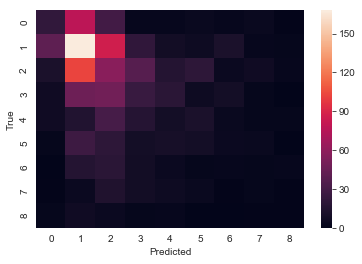

In [215]:
plot_confusion_mat(y, cross_val_predict(mlp, X_norm, y, cv=kf))

In [ ]:
lin_svc = svm.SVC()
eval_model(lin_svc, X_norm_ovl, y_ovl)

In [ ]:
neigh = RandomForestClassifier(n_estimators=100, max_depth=5)
eval_model(neigh, X_norm, y)

In [ ]:
neigh = RandomForestClassifier(n_estimators=100, max_depth=4)
eval_model(neigh, X_norm_ovl, y_ovl)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=10)
eval_model(neigh, X_norm, y)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=10)
eval_model(neigh, X_norm_ovl, y_ovl)

In [ ]:
plot_confusion_mat(y, cross_val_predict(neigh, X_norm, y, cv=kf))

In [ ]:
model = xgb.XGBClassifier(n_estimators=100,  max_depth=5, gamma=1, feature_names=feats)
eval_model(model)

In [ ]:
plot_confusion_mat(y, cross_val_predict(model, X_norm, y, cv=kf))

In [ ]:
fmap = dict(zip(["f"+str(i) for i in range(len(df_train.drop(pred_name, axis=1).columns))],df_train.columns))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
df_imp = pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values()
df_imp.index = df_imp.index.map(fmap)
df_imp.plot(kind='barh', color='Gray')